# Data cleaning and corruption risk labeling

**Goal**: Create analysis-ready dataset with corruption risk labels for model training

**Tasks**:
1. Load baseline data
2. Drop 2024 (incomplete governance data)
3. Handle missing values
4. Create corruption risk labels based on governance thresholds
5. Validate labels against known scandals (1MDB Malaysia, Mozambique hidden debt)
6. Save processed dataset to `data/processed/`

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# set working directory to project root
# if running from notebooks/, go up one level; otherwise assume already at root
current_dir = os.getcwd()
if current_dir.endswith('notebooks'):
    os.chdir('..')
elif 'notebooks' in current_dir:
    # if notebooks is in the path, go to project root
    project_root = current_dir.split('notebooks')[0].rstrip('/')
    if os.path.exists(project_root):
        os.chdir(project_root)

# verify we're in the right place
print(f"Working directory: {os.getcwd()}")
print(f"Data file exists: {os.path.exists('data/raw/corruption_data_baseline.csv')}")

# set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)

/var/folders/pk/_s3wzh8j3mbgc971jkb0__nc0000gn/T/ipykernel_38000/3927624813.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Working directory: /Users/snitil/Documents/innovationshowcase
Data file exists: True


## 1. Load and Inspect Data

In [2]:
# load the baseline data
df = pd.read_csv('data/raw/corruption_data_baseline.csv')

print(f"Original dataset shape: {df.shape}")
print(f"Countries: {df['Country'].unique()}")
print(f"Years: {df['Year'].min()} to {df['Year'].max()}")
df.head()

Original dataset shape: (45, 13)
Countries: ['Canada' 'Malaysia' 'Mozambique']
Years: 2010 to 2024


,Country,Year,Voice_Accountability,Political_Stability,Government_Effectiveness,Regulatory_Quality,Rule_of_Law,Control_of_Corruption,External_Debt_perc_GNI,GDP_Growth_annual_perc,Govt_Expenditure_perc_GDP,FDI_Inflows_perc_GDP,Poverty_Headcount_Ratio
0,Canada,2010,1.352659,0.936318,1.777827,1.693430,1.798590,2.061873,NaN,3.090806,19.084707,1.837256,0.2
1,Canada,2011,1.380145,1.077176,1.772545,1.684840,1.727120,1.971133,NaN,3.137194,17.850268,2.137833,0.2
2,Canada,2012,1.437505,1.113016,1.756970,1.707195,1.756421,1.918904,NaN,1.755661,17.517520,2.700169,0.2
3,Canada,2013,1.453440,1.061422,1.780741,1.729891,1.747508,1.879378,NaN,2.325814,17.084882,3.629804,0.5
4,Canada,2014,1.412332,1.175504,1.753718,1.838725,1.886297,1.832193,NaN,2.873467,16.402050,3.553903,0.2


In [3]:
# check data types
df.dtypes

Country                       object
Year                           int64
Voice_Accountability         float64
Political_Stability          float64
Government_Effectiveness     float64
Regulatory_Quality           float64
Rule_of_Law                  float64
Control_of_Corruption        float64
External_Debt_perc_GNI       float64
GDP_Growth_annual_perc       float64
Govt_Expenditure_perc_GDP    float64
FDI_Inflows_perc_GDP         float64
Poverty_Headcount_Ratio      float64
dtype: object

In [4]:
# check for missing values
missing_counts = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100

missing_summary = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percent': missing_pct
})

print("\nMissing values summary:")
print(missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False))


Missing values summary:
                           Missing_Count  Missing_Percent
External_Debt_perc_GNI                31        68.888889
Poverty_Headcount_Ratio               25        55.555556
Govt_Expenditure_perc_GDP              7        15.555556
Voice_Accountability                   3         6.666667
Political_Stability                    3         6.666667
Government_Effectiveness               3         6.666667
Regulatory_Quality                     3         6.666667
Rule_of_Law                            3         6.666667
Control_of_Corruption                  3         6.666667


## 2. Drop 2024 Data (Incomplete)

2024 has no governance indicators available yet, only some economic data. Since governance indicators are crucial for our corruption labeling, we'll remove 2024. Note: Notebook 01 now excludes 2024, but we keep this check as a safety measure.

In [5]:
# drop 2024 rows
print(f"Rows before dropping 2024: {len(df)}")
df = df[df['Year'] != 2024].copy()
print(f"Rows after dropping 2024: {len(df)}")
print(f"Years now: {df['Year'].min()} to {df['Year'].max()}")

Rows before dropping 2024: 45
Rows after dropping 2024: 42
Years now: 2010 to 2023


## 3. Handle Missing Values

Now let's see what missing data remains after dropping 2024.

In [6]:
# check missing values again after dropping 2024
missing_counts = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100

missing_summary = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percent': missing_pct
})

print("Missing values after removing 2024:")
print(missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False))

Missing values after removing 2024:
                           Missing_Count  Missing_Percent
External_Debt_perc_GNI                28        66.666667
Poverty_Headcount_Ratio               22        52.380952
Govt_Expenditure_perc_GDP              4         9.523810


In [7]:
# let's see which specific rows have missing governance indicators
governance_cols = ['Voice_Accountability', 'Political_Stability', 'Government_Effectiveness', 
                   'Regulatory_Quality', 'Rule_of_Law', 'Control_of_Corruption']

# check if any governance indicators are missing
missing_governance = df[df[governance_cols].isnull().any(axis=1)]
print(f"\nRows with missing governance indicators: {len(missing_governance)}")
if len(missing_governance) > 0:
    print(missing_governance[['Country', 'Year'] + governance_cols])


Rows with missing governance indicators: 0


In [8]:
# check which economic indicators have missing values and where
economic_cols = ['External_Debt_perc_GNI', 'GDP_Growth_annual_perc', 
                 'Govt_Expenditure_perc_GDP', 'FDI_Inflows_perc_GDP', 'Poverty_Headcount_Ratio']

print("\nMissing economic indicators by country-year:")
for col in economic_cols:
    missing_rows = df[df[col].isnull()]
    if len(missing_rows) > 0:
        print(f"\n{col}:")
        print(missing_rows[['Country', 'Year', col]])


Missing economic indicators by country-year:

External_Debt_perc_GNI:
     Country  Year  External_Debt_perc_GNI
0     Canada  2010                     NaN
1     Canada  2011                     NaN
2     Canada  2012                     NaN
3     Canada  2013                     NaN
4     Canada  2014                     NaN
5     Canada  2015                     NaN
6     Canada  2016                     NaN
7     Canada  2017                     NaN
8     Canada  2018                     NaN
9     Canada  2019                     NaN
10    Canada  2020                     NaN
11    Canada  2021                     NaN
12    Canada  2022                     NaN
13    Canada  2023                     NaN
15  Malaysia  2010                     NaN
16  Malaysia  2011                     NaN
17  Malaysia  2012                     NaN
18  Malaysia  2013                     NaN
19  Malaysia  2014                     NaN
20  Malaysia  2015                     NaN
21  Malaysia  2016        

### Missing Data Strategy

**Governance indicators**: Critical for labeling - if any are missing, we can't create reliable labels

**Economic indicators**: Less critical for initial labeling (which uses governance only), but needed for model features
- For minor gaps: forward fill within same country
- For larger gaps: document and potentially drop or use model that handles missing values

In [9]:
# forward fill economic indicators within each country
# this assumes values change slowly year-over-year
for col in economic_cols:
    df[col] = df.groupby('Country')[col].fillna(method='ffill')

# check remaining missing values
print("\nMissing values after forward fill:")
missing_after = df[economic_cols].isnull().sum()
print(missing_after[missing_after > 0])


Missing values after forward fill:
External_Debt_perc_GNI     28
Poverty_Headcount_Ratio     5
dtype: int64


/var/folders/pk/_s3wzh8j3mbgc971jkb0__nc0000gn/T/ipykernel_38000/3001721168.py:4: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df[col] = df.groupby('Country')[col].fillna(method='ffill')
/var/folders/pk/_s3wzh8j3mbgc971jkb0__nc0000gn/T/ipykernel_38000/3001721168.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df.groupby('Country')[col].fillna(method='ffill')
/var/folders/pk/_s3wzh8j3mbgc971jkb0__nc0000gn/T/ipykernel_38000/3001721168.py:4: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df[col] = df.groupby('Country')[col

In [10]:
# check final missing value status
print("\nFinal missing value summary:")
print(df.isnull().sum())


Final missing value summary:
Country                       0
Year                          0
Voice_Accountability          0
Political_Stability           0
Government_Effectiveness      0
Regulatory_Quality            0
Rule_of_Law                   0
Control_of_Corruption         0
External_Debt_perc_GNI       28
GDP_Growth_annual_perc        0
Govt_Expenditure_perc_GDP     0
FDI_Inflows_perc_GDP          0
Poverty_Headcount_Ratio       5
dtype: int64


## 4. Create Corruption Risk Labels

**Labeling Strategy**:
- Apply 6 governance threshold checks:
  1. Voice & Accountability < 1.15 → flag
  2. Political Stability < 0.50 → flag
  3. Government Effectiveness < 1.15 → flag
  4. Regulatory Quality < 1.15 → flag
  5. Rule of Law < 1.15 → flag
  6. Control of Corruption < 1.15 → flag

- **If 4+ flags → label as 1 (high risk)**
- **Otherwise → label as 0 (low risk)**

In [11]:
# define thresholds
thresholds = {
    'Voice_Accountability': 1.15,
    'Political_Stability': 0.50,
    'Government_Effectiveness': 1.15,
    'Regulatory_Quality': 1.15,
    'Rule_of_Law': 1.15,
    'Control_of_Corruption': 1.15
}

# create flag columns for each indicator
for indicator, threshold in thresholds.items():
    flag_col = f'{indicator}_flag'
    df[flag_col] = (df[indicator] < threshold).astype(int)

# count total flags per row
flag_cols = [f'{ind}_flag' for ind in thresholds.keys()]
df['total_flags'] = df[flag_cols].sum(axis=1)

# create corruption risk label: 4+ flags = high risk (1)
df['corruption_risk'] = (df['total_flags'] >= 4).astype(int)

print(f"\nFlag distribution:")
print(df['total_flags'].value_counts().sort_index())
print(f"\nRisk label distribution:")
print(df['corruption_risk'].value_counts())


Flag distribution:
total_flags
0    14
6    28
Name: count, dtype: int64

Risk label distribution:
corruption_risk
1    28
0    14
Name: count, dtype: int64


In [12]:
# show sample of labeled data
print("\nSample of labeled data:")
df[['Country', 'Year', 'total_flags', 'corruption_risk'] + list(thresholds.keys())].head(15)


Sample of labeled data:


,Country,Year,total_flags,corruption_risk,Voice_Accountability,Political_Stability,Government_Effectiveness,Regulatory_Quality,Rule_of_Law,Control_of_Corruption
0,Canada,2010,0,0,1.352659,0.936318,1.777827,1.693430,1.798590,2.061873
1,Canada,2011,0,0,1.380145,1.077176,1.772545,1.684840,1.727120,1.971133
2,Canada,2012,0,0,1.437505,1.113016,1.756970,1.707195,1.756421,1.918904
3,Canada,2013,0,0,1.453440,1.061422,1.780741,1.729891,1.747508,1.879378
4,Canada,2014,0,0,1.412332,1.175504,1.753718,1.838725,1.886297,1.832193
5,Canada,2015,0,0,1.467299,1.262337,1.730935,1.706058,1.807141,1.845650
6,Canada,2016,0,0,1.445611,1.240412,1.744541,1.727414,1.800915,1.944466
7,Canada,2017,0,0,1.478084,1.089681,1.815573,1.879656,1.763439,1.881446
8,Canada,2018,0,0,1.502411,0.963971,1.675134,1.699420,1.715142,1.790208
9,Canada,2019,0,0,1.430308,0.994934,1.697311,1.710002,1.719776,1.729897


## 5. Validate Labels Against Known Scandals

**Expected Results**:
- **Malaysia 2013-2015**: Should be labeled as high risk (1) due to 1MDB scandal
- **Mozambique 2013-2016**: Should be labeled as high risk (1) due to hidden debt crisis
- **Canada**: Should be mostly low risk (0) as control country

In [13]:
# check malaysia during 1MDB scandal period (2013-2015)
print("Malaysia 1MDB scandal period (2013-2015):")
malaysia_scandal = df[(df['Country'] == 'Malaysia') & (df['Year'].between(2013, 2015))]
print(malaysia_scandal[['Country', 'Year', 'total_flags', 'corruption_risk'] + flag_cols])
print(f"\nAll flagged as high risk? {malaysia_scandal['corruption_risk'].all()}")

Malaysia 1MDB scandal period (2013-2015):
     Country  Year  total_flags  corruption_risk  Voice_Accountability_flag  \
18  Malaysia  2013            6                1                          1   
19  Malaysia  2014            6                1                          1   
20  Malaysia  2015            6                1                          1   

    Political_Stability_flag  Government_Effectiveness_flag  \
18                         1                              1   
19                         1                              1   
20                         1                              1   

    Regulatory_Quality_flag  Rule_of_Law_flag  Control_of_Corruption_flag  
18                        1                 1                           1  
19                        1                 1                           1  
20                        1                 1                           1  

All flagged as high risk? True


In [14]:
# check mozambique during hidden debt crisis (2013-2016)
print("Mozambique hidden debt period (2013-2016):")
mozambique_scandal = df[(df['Country'] == 'Mozambique') & (df['Year'].between(2013, 2016))]
print(mozambique_scandal[['Country', 'Year', 'total_flags', 'corruption_risk'] + flag_cols])
print(f"\nAll flagged as high risk? {mozambique_scandal['corruption_risk'].all()}")

Mozambique hidden debt period (2013-2016):
       Country  Year  total_flags  corruption_risk  Voice_Accountability_flag  \
33  Mozambique  2013            6                1                          1   
34  Mozambique  2014            6                1                          1   
35  Mozambique  2015            6                1                          1   
36  Mozambique  2016            6                1                          1   

    Political_Stability_flag  Government_Effectiveness_flag  \
33                         1                              1   
34                         1                              1   
35                         1                              1   
36                         1                              1   

    Regulatory_Quality_flag  Rule_of_Law_flag  Control_of_Corruption_flag  
33                        1                 1                           1  
34                        1                 1                           1  
35     

In [15]:
# check canada (control country)
print("Canada (control country):")
canada = df[df['Country'] == 'Canada']
print(canada[['Country', 'Year', 'total_flags', 'corruption_risk']].head(10))
print(f"\nProportion flagged as high risk: {canada['corruption_risk'].mean():.2%}")
print(f"Total high risk years: {canada['corruption_risk'].sum()} / {len(canada)}")

Canada (control country):
  Country  Year  total_flags  corruption_risk
0  Canada  2010            0                0
1  Canada  2011            0                0
2  Canada  2012            0                0
3  Canada  2013            0                0
4  Canada  2014            0                0
5  Canada  2015            0                0
6  Canada  2016            0                0
7  Canada  2017            0                0
8  Canada  2018            0                0
9  Canada  2019            0                0

Proportion flagged as high risk: 0.00%
Total high risk years: 0 / 14


In [16]:
# summary by country
print("\nCorruption risk summary by country:")
country_summary = df.groupby('Country').agg({
    'corruption_risk': ['sum', 'mean'],
    'total_flags': ['mean', 'max']
})
country_summary.columns = ['High_Risk_Years', 'High_Risk_Rate', 'Avg_Flags', 'Max_Flags']
print(country_summary)


Corruption risk summary by country:
            High_Risk_Years  High_Risk_Rate  Avg_Flags  Max_Flags
Country                                                          
Canada                    0             0.0        0.0          0
Malaysia                 14             1.0        6.0          6
Mozambique               14             1.0        6.0          6


In [17]:
# create directory for notebook 02 figures
os.makedirs('results/figures/02', exist_ok=True)
print("Figures will be saved to: results/figures/02/")


Figures will be saved to: results/figures/02/


## 6. Visualizations

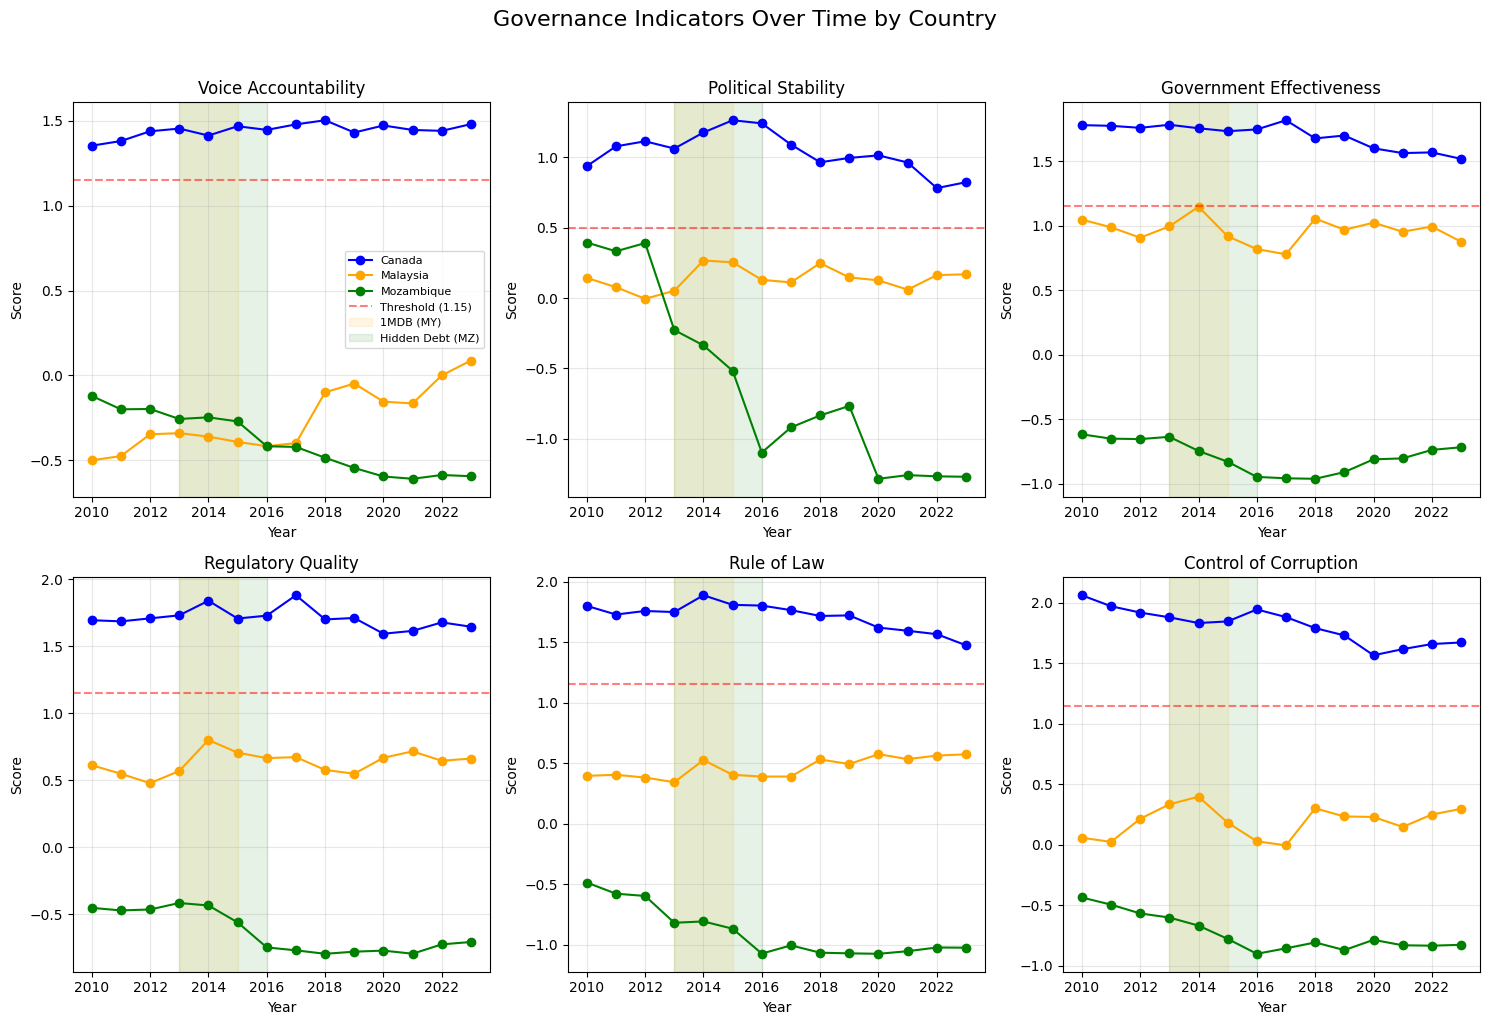

In [18]:
# plot governance scores over time by country
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Governance Indicators Over Time by Country', fontsize=16, y=1.02)

indicators = list(thresholds.keys())
countries = df['Country'].unique()
colors = {'Canada': 'blue', 'Malaysia': 'orange', 'Mozambique': 'green'}

for idx, indicator in enumerate(indicators):
    ax = axes[idx // 3, idx % 3]
    
    for country in countries:
        country_data = df[df['Country'] == country]
        ax.plot(country_data['Year'], country_data[indicator], 
                marker='o', label=country, color=colors[country])
    
    # add threshold line
    threshold = thresholds[indicator]
    ax.axhline(y=threshold, color='red', linestyle='--', alpha=0.5, label=f'Threshold ({threshold})')
    
    # highlight scandal periods
    ax.axvspan(2013, 2015, alpha=0.1, color='orange', label='1MDB (MY)')
    ax.axvspan(2013, 2016, alpha=0.1, color='green', label='Hidden Debt (MZ)')
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Score')
    ax.set_title(indicator.replace('_', ' '))
    ax.grid(True, alpha=0.3)
    if idx == 0:
        ax.legend(loc='best', fontsize=8)

plt.tight_layout()
plt.savefig('results/figures/02/governance_indicators_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

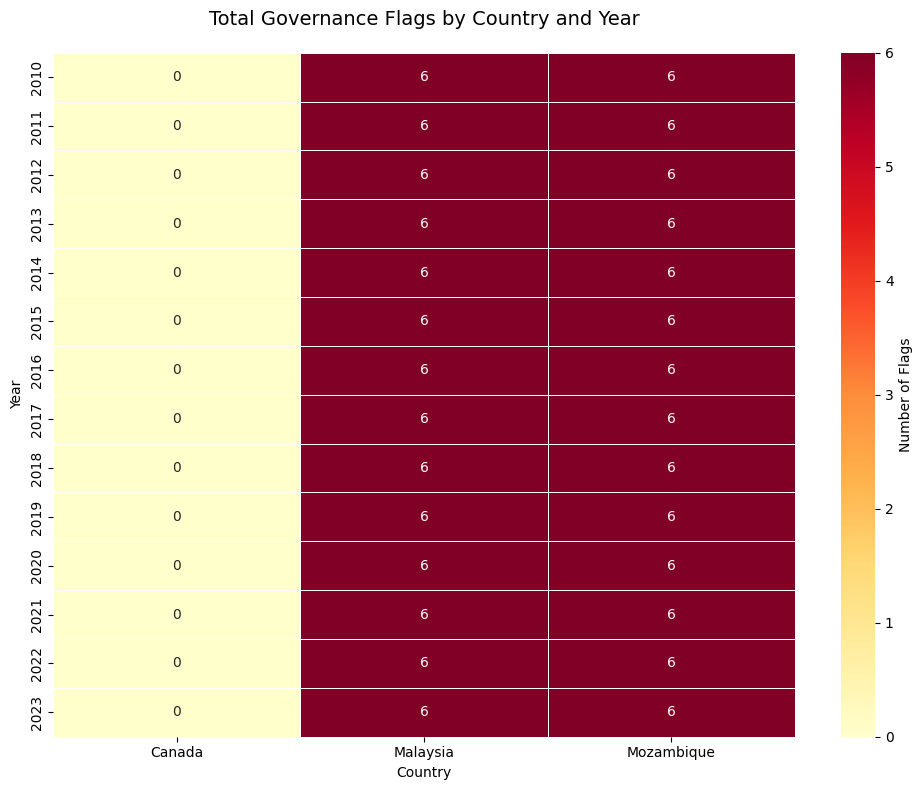

In [19]:
# create flag heatmap by country and year
pivot_flags = df.pivot_table(index='Year', columns='Country', values='total_flags')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_flags, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Number of Flags'}, linewidths=0.5)
plt.title('Total Governance Flags by Country and Year', fontsize=14, pad=20)
plt.ylabel('Year')
plt.xlabel('Country')
plt.tight_layout()
plt.savefig('results/figures/02/corruption_flags_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

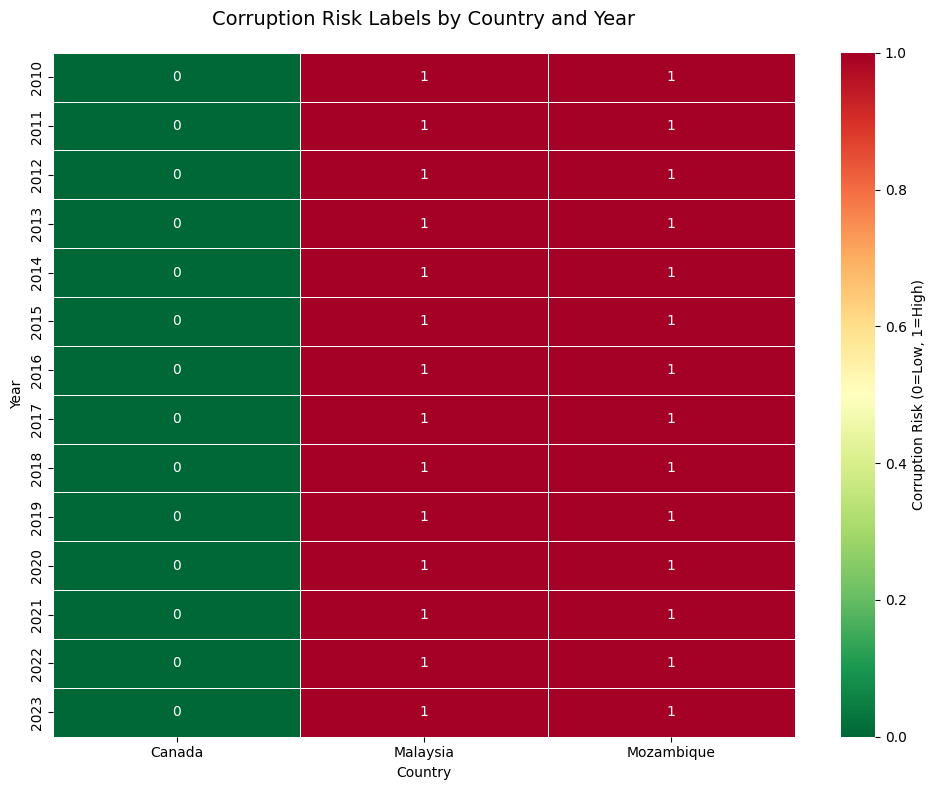

In [20]:
# create risk label visualization
pivot_risk = df.pivot_table(index='Year', columns='Country', values='corruption_risk')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_risk, annot=True, fmt='.0f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Corruption Risk (0=Low, 1=High)'}, linewidths=0.5, vmin=0, vmax=1)
plt.title('Corruption Risk Labels by Country and Year', fontsize=14, pad=20)
plt.ylabel('Year')
plt.xlabel('Country')
plt.tight_layout()
plt.savefig('results/figures/02/corruption_risk_labels.png', dpi=300, bbox_inches='tight')
plt.show()

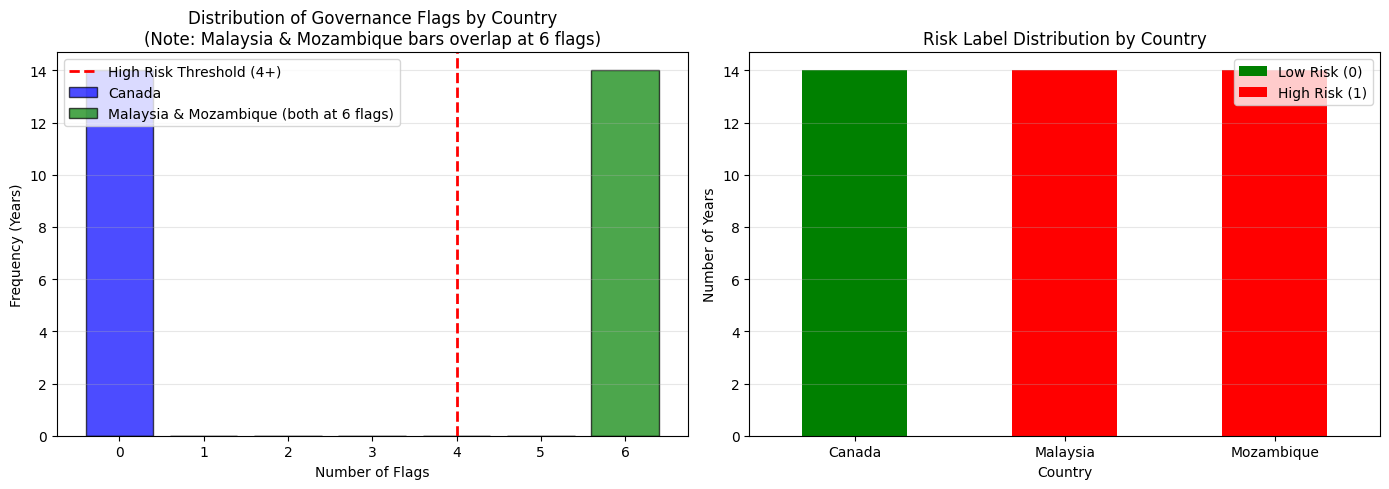

In [21]:
# distribution of flags
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# flag distribution by country - using bar chart for discrete values
# Note: Malaysia and Mozambique both have 6 flags for all 14 years, so they overlap at x=6
flag_values = [0, 1, 2, 3, 4, 5, 6]

# count frequencies for each country
canada_counts = [sum(df[df['Country'] == 'Canada']['total_flags'] == i) for i in flag_values]
malaysia_counts = [sum(df[df['Country'] == 'Malaysia']['total_flags'] == i) for i in flag_values]
mozambique_counts = [sum(df[df['Country'] == 'Mozambique']['total_flags'] == i) for i in flag_values]

# plot bars - Malaysia and Mozambique will visually overlap at x=6 since both have identical values
axes[0].bar(flag_values, canada_counts, alpha=0.7, label='Canada', color='blue', edgecolor='black', width=0.8)
axes[0].bar(flag_values, malaysia_counts, alpha=0.7, label='Malaysia & Mozambique (both at 6 flags)', 
            color='green', edgecolor='black', width=0.8)
# Mozambique is not plotted separately since it has identical values to Malaysia and would be invisible

axes[0].axvline(x=4, color='red', linestyle='--', linewidth=2, label='High Risk Threshold (4+)')
axes[0].set_xlabel('Number of Flags')
axes[0].set_ylabel('Frequency (Years)')
axes[0].set_title('Distribution of Governance Flags by Country\n(Note: Malaysia & Mozambique bars overlap at 6 flags)')
axes[0].set_xticks(flag_values)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# risk label distribution
risk_counts = df.groupby('Country')['corruption_risk'].value_counts().unstack(fill_value=0)
risk_counts.plot(kind='bar', stacked=True, ax=axes[1], color=['green', 'red'])
axes[1].set_xlabel('Country')
axes[1].set_ylabel('Number of Years')
axes[1].set_title('Risk Label Distribution by Country')
axes[1].legend(['Low Risk (0)', 'High Risk (1)'])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/figures/02/flag_risk_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Save Processed Dataset

Save the labeled dataset to `data/processed/` for model training

In [22]:
# show final columns
print("Final dataset columns:")
print(df.columns.tolist())

Final dataset columns:
['Country', 'Year', 'Voice_Accountability', 'Political_Stability', 'Government_Effectiveness', 'Regulatory_Quality', 'Rule_of_Law', 'Control_of_Corruption', 'External_Debt_perc_GNI', 'GDP_Growth_annual_perc', 'Govt_Expenditure_perc_GDP', 'FDI_Inflows_perc_GDP', 'Poverty_Headcount_Ratio', 'Voice_Accountability_flag', 'Political_Stability_flag', 'Government_Effectiveness_flag', 'Regulatory_Quality_flag', 'Rule_of_Law_flag', 'Control_of_Corruption_flag', 'total_flags', 'corruption_risk']


In [23]:
# save to processed directory
output_path = 'data/processed/corruption_data_labeled.csv'
df.to_csv(output_path, index=False)
print(f"saved to: {output_path}")
print(f"Shape: {df.shape}")
print(f"Columns: {len(df.columns)}")

saved to: data/processed/corruption_data_labeled.csv
Shape: (42, 21)
Columns: 21


In [24]:
# final summary statistics
print(f"\nDataset: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Countries: {df['Country'].nunique()}")
print(f"Years: {df['Year'].min()} - {df['Year'].max()}")
print(f"\nCorruption Risk Distribution:")
print(f"  Low Risk (0): {(df['corruption_risk'] == 0).sum()} rows ({(df['corruption_risk'] == 0).mean():.1%})")
print(f"  High Risk (1): {(df['corruption_risk'] == 1).sum()} rows ({(df['corruption_risk'] == 1).mean():.1%})")
print(f"\nMalaysia 2013-2015 flagged: {malaysia_scandal['corruption_risk'].all()}")
print(f"Mozambique 2013-2016 flagged: {mozambique_scandal['corruption_risk'].all()}")


Dataset: 42 rows, 21 columns
Countries: 3
Years: 2010 - 2023

Corruption Risk Distribution:
  Low Risk (0): 14 rows (33.3%)
  High Risk (1): 28 rows (66.7%)

Malaysia 2013-2015 flagged: True
Mozambique 2013-2016 flagged: True
